In [1]:
import math
import datetime as dt

import xarray as xr
#Load netCDF
from netCDF4 import Dataset

import numpy as np
from numpy.linalg import inv

import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import inv as spinv
import scipy.stats as stats

import pandas as pd

from os import remove, listdir
from os.path import isfile, join

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cartopy.crs as ccrs
import cartopy

import sys
sys.path.append('/Users/hannahnesser/Documents/Harvard/Research/Python')
# import inv_plot

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

%matplotlib inline

In [2]:
# %matplotlib inline
# #Set up the ipython notebook
# import numpy as np
# import scipy as sp
# import matplotlib.pyplot as plt
# import pandas as pd
# pd.set_option('display.width', 600)
# pd.set_option('display.max_columns', 120)
# import seaborn as sns
# #sns.set_style("white")
# import re
# from copy import copy

# #Load plotting package Basemap
# from mpl_toolkits.basemap import Basemap
# from matplotlib.colors import LogNorm

# #Set up ticker
# import matplotlib.ticker as ticker

# #Load netCDF
# from netCDF4 import Dataset

# #Generate HD plots
# import matplotlib
# # matplotlib.rcParams['savefig.dpi'] = 5 * matplotlib.rcParams['savefig.dpi']

# # #Set font for superscript
# # params = {'mathtext.default': 'regular' }          
# # plt.rcParams.update(params)

# #Define constants
# Avagrado   = 6.02214129 * 10**(23)  #molecules/mol
# Molarch4   = 16.04 #g/mol

# #Prevent annoying auto_scroll

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
#Read landfraction array
# are_f = Dataset('MERRA2.20150101.CN.05x0625.NA.nc4')
# Lon = np.array(are_f.variables['lon'])
# Lat = np.array(are_f.variables['lat'])
# Land = np.array(are_f.variables['FRLAND'])[0,:,:]
# Land += np.array(are_f.variables['FRLAKE'])[0,:,:]
# Land += np.array(are_f.variables['FRLANDIC'])[0,:,:]
# are_f.close()

temp = xr.open_dataset('MERRA2.20150101.CN.05x0625.NA.nc4')
lat = temp.coords['lat'].values
lon = temp.coords['lon'].values
land = temp['FRLAND'][0,:,:] + temp['FRLAKE'][0,:,:] + temp['FRLANDIC'][0,:,:]

In [5]:
emi_all = np.zeros(land.shape)
for f in listdir('05x0625_NA/GEPA'):
    if (f[0] != '.') and (isfile('05x0625_NA/GEPA/' + f)):
        emi_all += xr.open_dataset('05x0625_NA/GEPA/' + f,
                                   autoclose=True) ['emi_ch4'][0,:,:]

for i in np.arange(12):
    emi_all += xr.open_dataset('05x0625_NA/JPL_Wetlands/EMICH4_11_JPLW_Wetlands_05x0625_NA_2009.nc',
                               autoclose=True)['emi_ch4'][i,:,:]/12

for i in np.arange(365):
    emi_all += xr.open_dataset('05x0625_NA/QFED/EMICH4_10_QFED_Biomass_Burning_05x0625_NA_2009.nc',
                               autoclose=True)['emi_ch4'][0,:,:]/365
    
emi_all += xr.open_dataset('05x0625_NA/Lakes/EMICH4_13_Lakes_05x0625_NA.nc')['emi_ch4'][0,:,:]
emi_all += xr.open_dataset('05x0625_NA/Seeps/EMICH4_12_Geological_Seeps_05x0625_NA.nc')['emi_ch4'][0,:,:]
emi_all += xr.open_dataset('05x0625_NA/Termites/EMICH4_14_Termites_05x0625_NA.nc')['CH4_EMIS__CH4_OTN'][0,:,:]

In [6]:
emi_all.sum()

<xarray.DataArray 'emi_ch4' ()>
array(4.781552e+15)
Coordinates:
    time     datetime64[ns] 2009-01-01

In [7]:
emi_all_07 = xr.open_dataset('../Perturbation_Runs/0000/HEMCO_diagnostics.200907010000.nc')
emi_all_07.coords['lev'] = emi_all_07['lev'].round(6)
    
# remove the level parameter (since we're talking about ground level emissions)
emi_all_07 = emi_all_07.where(emi_all_07.lev == emi_all_07.lev.min(), drop=True)
emi_all_07 = emi_all_07.drop(['lev', 'hyam', 'hybm', 'P0', 'EmisCH4_SoilAbsorb'])
emi_all_07 = emi_all_07.squeeze('lev')

emi_all_07['EmisCH4_Total'] = emi_all_07['EmisCH4_Total'] - emi_all_07['EmisCH4_Total']

for i, var in enumerate(emi_all_07.data_vars):
    if (var[:4] == 'Emis') & (var[8:] != 'Total'):
        # convert from kg/m2 s to kg/s
        emi_all_07[var] = emi_all_07[var]*emi_all_07['AREA']

        # convert from kg/s to kg
        emi_all_07[var] = emi_all_07[var]*(60*60*24*365/12)

        emi_all_07['EmisCH4_Total'] += emi_all_07[var]
        
        # rename the variable
        emi_all_07 = emi_all_07.rename({var : var[8:]})

emi_all_07 = emi_all_07.rename({'EmisCH4_Total' : 'Total'})

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
emi_all_07['Total'].where(emi_all_07['Total'] > 1e4).plot(ax=ax)#.plot(cmap='viridis')
ax.set_title('Emissions > 1e4 kg/month')

print(emi_all_07['lat'].min(), emi_all_07['lat'].max())
print(emi_all_07['lon'].min(), emi_all_07['lon'].max())

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/hannahnesser/Documents/Harvard/Research/Reduced_Rank_Jacobian/Perturbation_Runs/0000/HEMCO_diagnostics.200907010000.nc'

In [ ]:
# fig, ax = plt.subplots(figsize=(20,8),
#                        subplot_kw={'projection': ccrs.PlateCarree()})

lim1 = 1e10
lim2 = 1.5e10

fig, ax = plt.subplots(1,2,figsize=(21,5),
                       subplot_kw={'projection': ccrs.PlateCarree()})
emi_all.where(emi_all > lim1).plot(ax=ax[0])
emi_all.where(emi_all > lim2).plot(ax=ax[1]);

ax[0].set_title('Emissions > %.1e' % lim1)
ax[1].set_title('Emissions > %.1e' % lim2)

for axis in ax:
    axis.coastlines(color='white')
#     cluster.where(cluster==823, drop=True).plot(color='red', add_colorbar=False)

print(emi_all_07['lat'].min(), emi_all_07['lat'].max())
print(emi_all_07['lon'].min(), emi_all_07['lon'].max())

In [22]:
# Cluster = np.zeros([Land.shape[0],Land.shape[1]])

# Clusti = 1
# for i in np.arange(Land.shape[0]):
#     for j in np.arange(Land.shape[1]):
# #         if Land[i,j] > 0.001 or Emi_All[i,j] > 1e9:
#         if Emi_All[i,j] > 1e9:
# #             if Emi_All[i,j] > 0:
#             Cluster[i,j] = Clusti
#             Clusti += 1

# Cluster = np.zeros([Land.shape[0],Land.shape[1]])

# Clusti = 1
# for i in np.arange(Land.shape[0]/2):
#     for j in np.arange(Land.shape[1]/2):
#         if np.nanmean(Emi_All[i*2:i*2+2,j*2:j*2+2]) > 1e9:
#             Cluster[i*2:i*2+2,j*2:j*2+2] = Clusti
#             Clusti += 1

# t = dt.datetime(2009,1,1)
cluster_1x125 = xr.DataArray(np.zeros((1,) + land.shape),
                       coords=[[np.double(0)], lat, lon], 
                       dims=['time', 'lat', 'lon'])

cluster_1x125.time.attrs = [('calendar', 'standard'),
                            ('long_name', 'Time'),
                            ('units', 'hours since 2009-01-01 00:00:00'),
                            ('cell_methods', 'time: mean')]

cluster_1x125.lat.attrs = [('standard_name', 'latitude'),
                           ('long_name', 'Latitude'),
                           ('units', 'degrees_north')]

cluster_1x125.lon.attrs = [('standard_name', 'longitude'),
                           ('long_name', 'Longitude'),
                           ('units', 'degrees_east')]

clusti = 1
for i in range(math.floor(cluster_1x125.shape[1]/2)):
    for j in range(math.floor(cluster_1x125.shape[2]/2)):
        if np.mean(emi_all[i*2:i*2+2, j*2:j*2+2]) > 1.5e10:
            cluster_1x125[0, i*2:i*2+2, j*2:j*2+2] = np.float(clusti)
            clusti += 1
            
fine_cluster = cluster_1x125.copy()
fine_cluster.values = np.zeros((1,) + land.shape)
clusti = 1
for i in range(fine_cluster.shape[1]):
    for j in range(fine_cluster.shape[2]):
        if emi_all[i, j] > 1.5e10:
            fine_cluster[0, i, j] = np.float(clusti)
            clusti += 1
            
cluster_2x25 = cluster_1x125.copy()
cluster_2x25.values = np.zeros((1,) + land.shape)
clusti = 1
for i in range(math.floor(cluster_2x25.shape[1]/4)):
    for j in range(math.floor(cluster_2x25.shape[2]/4)):
        if np.mean(emi_all[i*4:i*4+4, j*4:j*4+4]) > 1.5e10:
            cluster_2x25[0, i*4:i*4+4, j*4:j*4+4] = np.float(clusti)
            clusti += 1

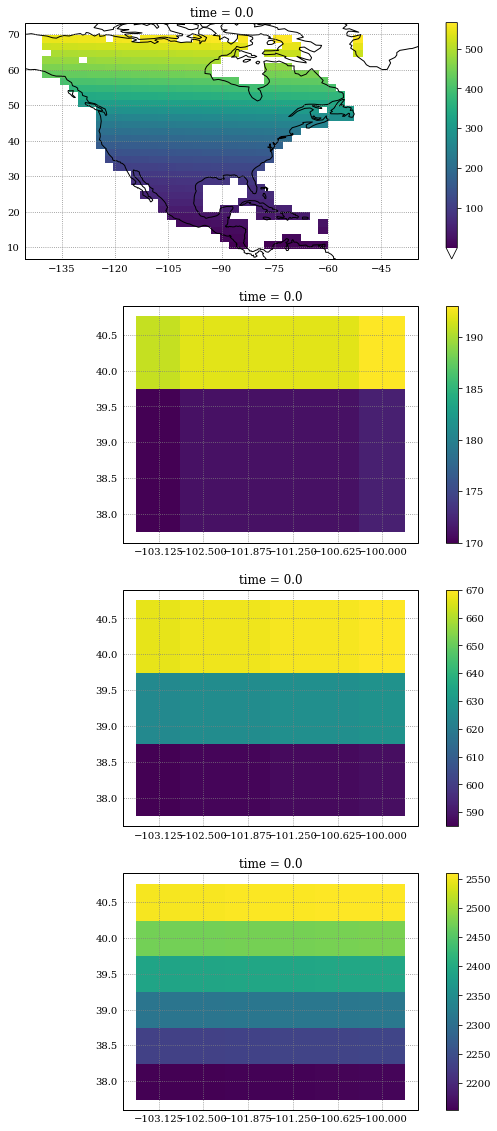

In [23]:
cm = plt.cm.get_cmap('viridis')
cm.set_under('white', alpha=0)

fig, ax = plt.subplots(4,1,figsize=(10,20),subplot_kw={'projection' : ccrs.PlateCarree()})
cluster_2x25[0,:,:].plot(cmap=cm, vmin=1, ax=ax[0])
cluster_2x25.loc[:, slice(38, 40.5), slice(-103.5, -100)].plot(ax=ax[1])
cluster_1x125.loc[:, slice(38, 40.5), slice(-103.5, -100)].plot(ax=ax[2])
fine_cluster.loc[:, slice(38, 40.5), slice(-103.5, -100)].plot(ax=ax[3])

i = 0
for axis in ax:
    axis.coastlines()
    gl = axis.gridlines(linestyle=':', draw_labels=True, color='grey')
    gl.xlabels_top = False
    gl.ylabels_right = False
    if i > 0:
        gl.xlocator = matplotlib.ticker.FixedLocator(lon)
        gl.ylocator = matplotlib.ticker.FixedLocator(lat)
        
    i += 1

In [24]:
clusts = {'1x125' : cluster_1x125, '2x25' : cluster_2x25}
for grid, cluster_da in clusts.items():
    cluster_ds = cluster_da.to_dataset(name='Clusters')
    cluster_ds.attrs['description'] = 'Clusters Generated %s, HON' % dt.datetime.today().strftime('%m/%d') 
    cluster_ds.Clusters.attrs = [('standard_name', 'Clusters'),
                                 ('long_name', 'Clusters'),
                                 ('units', 'none')]
    # cluster_ds
    cluster_ds.to_netcdf('Clusters_NA_%s.nc' % grid, 'w', unlimited_dims=['time'])

In [203]:
cluster_ds.Clusters.attrs

OrderedDict([('standard_name', 'Clusters'),
             ('long_name', 'Clusters'),
             ('units', 'none')])

In [39]:
nc_out = Dataset('Clusters_45_July.nc', 'w', format='NETCDF4')
nc_out.description = 'Clusters generated 11/18, HON'

#Create dimensions
nc_out.createDimension('lat', len(lat))
nc_out.createDimension('lon', len(lon))
nc_out.createDimension('time', 1)

#Create variables
latitudes = nc_out.createVariable('Lat', 'f4', ('cols',))
longitudes = nc_out.createVariable('Lon', 'f4', ('rows',))
data_out = nc_out.createVariable('clusters', 'f4', ('cols', 'rows',), zlib=True)

#Properties
longitudes.standard_name = "Lon" 
latitudes.standard_name = "Lat" 
data_out.standard_name = "clusters" 

#Put data into the arrays
latitudes[:]  = lat
longitudes[:] = lon
data_out[:,:] = cluster['clusters'].values

#Close the file
nc_out.close()

In [37]:
cluster['clusters'].values

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [2402., 2402., 2403., ...,    0.,    0.,    0.],
       [2402., 2402., 2403., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])